# Titanic: Machine Learning from Disaster

## Introduction
Titanic is a famous ship that sank on 15 April 1912 after colliding with an iceberg. 
There were 2224 passengers and 1502 died making it one of the deadliest disaster of the modern history. <sup>[1]</sup>

Our job here is to build a model that answers how likely people were to survive this disaster. <br />
The process we'll be as following:
1. Data Exploration and Visualization
2. Feature Engineering

## Source
1. https://en.wikipedia.org/wiki/RMS_Titanic

In [60]:
# from math stuff
import numpy as np
# for handling the dataset
import pandas as pd
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier

sns.set(style="white", context="talk")
%matplotlib inline

## Data Exploration and Visualization
First of all, let's load and explore the dataset.

In [19]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print('train size: {0}; test size: {1}'.format(len(train), len(test)))

train size: 891; test size: 418


We have a training set with 891 samples and a testing set with 418 samples. <br />
Let's take a preview on training set.

In [58]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here, we can see that our response variable (label) is **Survived** and it's a categorical variable. <br />
This means that we'll be using a classifier as prediction model.

The other ones are explanatory variables and there are categorical and continuous variables.

We can see the feature **Cabin** has NaN values. This is a problem the should be handled. <br />
Let's take an overview on dataset and see the quantity of NaN values.

In [80]:
print('***TRAINING SET***')
print(train.isnull().sum())
print('\n***TESTING SET***')
print(test.isnull().sum())

***TRAINING SET***
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

***TESTING SET***
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Now we can see that:
* The feature **Cabin** might be discarded since more than 70% of the data isn't provided.
* The feature **Embarked** has only 2 samples with NaN. We could discard the sample or impute values.
* The feature **Age** has 263 samples with NaN. This is about 20% of the data. Discarding the feature might be pretty much loss of information. So, we should be imputing new values.

Now, let's plot some graphs in order to get some insight about the dataset. <br />
Our response variable is **Survived**, so let's see the ratio between the Survived and Desceased people.

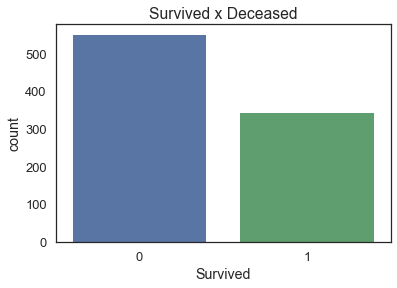

In [97]:
plt.title('Survived x Deceased')
sns.countplot(data=train, x='Survived')

Here we can see that most of the people desceased, but nothing more. <br />
Let's see the survivability rate between genders.

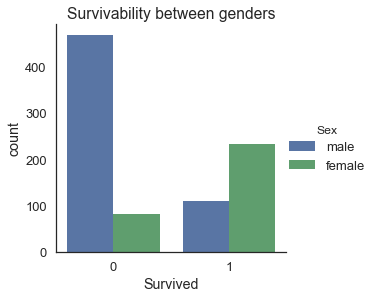

In [96]:
sns.factorplot(data=train, x='Survived', hue='Sex', kind='count')
plt.title('Survivability between genders')

Now, we have an interesting insight. Most of the men died on this disaster. <br />
This is due to the "women and children first" protocol while loading the safeboats.

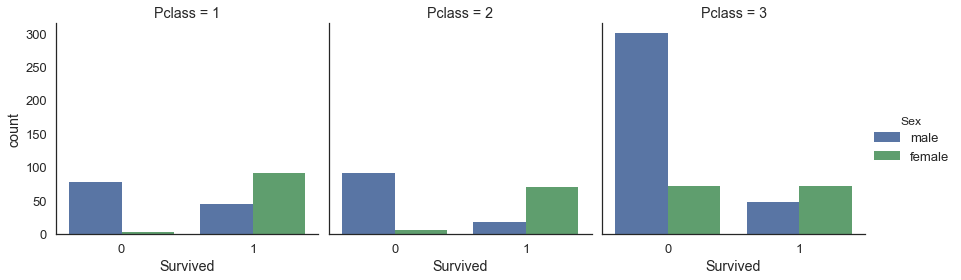

In [122]:
sns.factorplot(data=train, x='Survived', hue='Sex', col='Pclass', kind='count')

After we factored the plot between classes, we can see that women with higher class were more likely to survive.

---
## Feature Engineering
### Dealing with missing values
Before starting the feature engineering, we'll be merging both datasets in one.

In [186]:
X, y = train.iloc[:,2:], train.iloc[:,1] # separating the labels

In [187]:
X = pd.concat([X[:], test.iloc[:,1:][:]], ignore_index=True) # merging the datasets

In [188]:
print('total is {}'.format(len(X)))

total is 1309


Let's start with the easiest one. <br />
Embarked have only 2 samples with NaN, let's take a look on them.

In [189]:
X[X.Embarked.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can see that both of them are somehow related. <br />
They have the same ticket number, paid the same fare and shared the same cabin. Consequently, they might Embarked from the same place. <br />
We'll running a *Random Forest* here to impute **Embarked** since the classifier requires almost no feature engineering. <br />

In [190]:
_ = X[~X.Embarked.isnull() & ~X.Fare.isnull()][['Pclass', 'Fare', 'Embarked']].as_matrix()
clf = RandomForestClassifier()
clf.fit(_[:,:2], _[:,2])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
clf.predict(X[X.Embarked.isnull()][['Pclass', 'Fare']].as_matrix())

array(['S', 'S'], dtype=object)

In [199]:
X.loc[[61, 829],['Embarked']] = 'S'

In [200]:
X.loc[[61, 829]]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


The classifier predicted as they embarked from Southampton, so we'll be imputing 'S' to them.

age = train[~pd.isnull(train.Age)]

ax = sns.distplot(age[age.Survived == 0]['Age'])
sns.distplot(age[age.Survived == 1]['Age'], ax=ax)

plt.show()

sns.factorplot(data=train, x='Survived', hue='Sex', col='Embarked', row='Pclass', kind='count')

sns.countplot(data=train, x='Survived', hue='Embarked')
plt.show()